# Network Colocalization Notebook

Figures generated:
- Figure 2B
- Figure 2C
- Figure 2D
- Figure 2E


### Set Up

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy.stats import hypergeom
from scipy.stats import mannwhitneyu
import obonet as obo
import re
from tqdm import tqdm
from statsmodels.stats.multitest import fdrcorrection
from sklearn.metrics import roc_auc_score

In [2]:
datadir = '/cellar/users/snwright/Data/RareCommon/'
output_dir='/cellar/users/snwright/Data/RareCommon/outputs'
figdir='/cellar/users/snwright/Data/Transfer/RVC/figures/RVC_Results/'
input_dir= '/cellar/users/snwright/Data/RareCommon/inputs'

In [3]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 7})
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.4
plt.rcParams['ytick.major.width'] = 0.4
plt.rcParams['xtick.minor.width'] = 0.3
plt.rcParams['ytick.minor.width'] = 0.3
plt.rcParams['legend.frameon'] = False
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['ytick.minor.size'] = 2
plt.rcParams['xtick.major.pad'] = 1
plt.rcParams['ytick.major.pad'] = 1
plt.rcParams['axes.labelpad'] = 1
plt.rcParams['patch.linewidth'] = 0.5
import matplotlib.font_manager as fm
arial_font_path = '/cellar/users/snwright/Fonts/msfonts/Arial.TTF'
fm.fontManager.addfont(arial_font_path)
import matplotlib
matplotlib.rcParams['font.family'] = 'Arial'

In [4]:
import re
def map_trait_code(code):
    efo = next((match.group() for match in re.finditer(r'EFO_\d+', code)), None)
    if efo is not None:
        return efo
    mondo = next((match.group() for match in re.finditer(r'MONDO_\d+', code)), None)
    if mondo is not None:
        return mondo
    hp = next((match.group() for match in re.finditer(r'HP_\d+', code)), None)
    if hp is not None:
        return hp
    go = next((match.group() for match in re.finditer(r'GO_\d+', code)), None)
    if go is not None:
        return go
    oba = next((match.group() for match in re.finditer(r'OBA_\d+', code)), None)
    if oba is not None:
        return oba
    return None

## Load NetColoc Results

In [5]:
def load_files_from_list(outdir, job_id):
    with open(os.path.join(outdir, f'{job_id}.files'), 'r') as f:
        filenames = [s.strip() for s in f.readlines()] 
    loaded_data = []
    not_found = 0
    for f in filenames:
        try:
            loaded_data.append(pd.read_csv(os.path.join(outdir, f), sep='\t', header=None))
        except:
            not_found += 1
    print(f'Files loaded {len(loaded_data)}\n', f'Files not found {not_found}')
    results = pd.concat(loaded_data)
    results.columns = ['TraitR', 'TraitC', 'Network','Transform', 'Norm', 'Mean_NPS', 
                             'Null_mean_NPS', 'P_mean_NPS', 'Size', 'Null_Size', 'P_size' ]
    results['logp_nps'] = results.P_mean_NPS.apply(lambda x: -1 * np.log10(x+1e-250))
    results['logp_size'] = results.P_size.apply(lambda x: -1 * np.log10(x+1e-250))
    results['log2SizeOE'] = np.log2(results['Size'] / results['Null_Size'])
    return results


In [6]:
#df = pd.read_csv(os.path.join(output_dir, 'netcoloc/March_2025', 'rvc_qnetcoloc_rv_gc.txt'), sep='\t', header=None,
#                names =['TraitR', 'TraitC', 'Network','Transform', 'Norm','Mean_NPS', 'Null_mean_NPS', 'P_mean_NPS', 'Size', 'Null_Size', 'P_size' ])

df = load_files_from_list(os.path.join(output_dir, 'netcoloc', 'March_2025'), 2214576)
df['slurm_idx'] = [x for x in range(len(df))]
df['EFO'] = df.TraitR.apply(lambda x: map_trait_code(x))
df['StudyC'] = df.TraitC.apply(lambda x: next((match.group() for match in re.finditer(r'GCST\d+', x)), None))
df['StudyR'] = df.TraitR.apply(lambda x: x.split('_')[0])
df['trait_pair'] = df['TraitR'] + '_' + df['TraitC']

Files loaded 373
 Files not found 0


In [7]:
c_traitlist = pd.read_csv(os.path.join(input_dir, 'March_2025', 'common_Mar28.traitlist'), header=None)[0].values
r_traitlist = pd.read_csv(os.path.join(input_dir, 'March_2025', 'rare_Mar28.traitlist'), header=None)[0].values

In [8]:
trait_pairs = ['_'.join(x) for x in zip(r_traitlist, c_traitlist)]

In [9]:
df['q'] = fdrcorrection(df.P_size.values)[1]
df['logq'] = df.q.apply(lambda z: -1 * np.log10(z + 1e-250))
df['plot_color'] = df.logp_size.apply(lambda z: min(z, 50))

Load optimization results

In [10]:
opt_df = pd.read_csv('/cellar/users/snwright/Data/RareCommon/outputs/key_files/optimization_results.tsv', sep='\t', index_col=0)

## Figure 2B - Overall performance

In [11]:
fdr_df = opt_df[(opt_df.Norm=='sum')].dropna() # exclude binary results
fdr_df = fdr_df.sort_values(by='SizeOE', ascending=False)
fdr = []
val = []
fp = 0
tp = 0
for row in fdr_df.iterrows():
    if row[1]['Set'] == 'Test':
        tp +=1
    else:
        fp +=1
    fdr.append(fp / (fp+tp))
    val.append(row[1]['SizeOE'])


In [12]:
roc_auc_score(y_true=fdr_df.Set=='Test', y_score=fdr_df.SizeOE)

0.8394424367578731

Text(0, 0.5, 'COLOC Score')

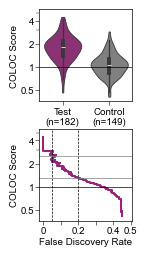

In [13]:
_, [ax1, ax2] = plt.subplots(nrows=2, ncols=1, figsize=(1.2, 2.75), sharey=True, gridspec_kw={'hspace':0.3})
sns.violinplot(fdr_df, x='Set', y='SizeOE', hue='Set', ax=ax1, cut=0, palette=['#97247C', 'grey'])
ax1.hlines(y=0, xmin=-0.5, xmax=1.5, color='black', linewidth=0.5)
ax1.set_xlim(-0.5, 1.5)
ax1.set_ylabel('COLOC Score')
_ = ax1.set_yticks([-1, 0,  1, 2], [0.5, 1, 2, 4])
_ = ax1.set_yticks(np.log2([3,5,6,7]), minor=True)

fdr_df = fdr_df.sort_values(by='SizeOE', ascending=False)
fdr = []
val = []
count_tp = []
sensitivity =[]
fp = 0
tp = 0
total_pos = fdr_df[fdr_df.Norm=='sum'].Set.value_counts()['Test']
for row in fdr_df.iterrows():
    if row[1]['Set'] == 'Test':
        tp +=1
    else:
        fp +=1
    count_tp.append(tp)
    fdr.append(fp / (fp+tp))
    val.append(row[1]['SizeOE'])
    sensitivity.append(tp/(total_pos))
    val

#_,  [ax1, ax2] = plt.subplots(nrows=2, ncols=1, figsize=(5, 5))
ax2.plot(fdr, val, color="#97247C", drawstyle="steps-post")
ax2.set_xlabel('False Discovery Rate')
_ = ax2.set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5], labels=[0, '', 0.2, '', 0.4, 0.5])



ax1.set_xticks([0,1], labels=[f'{s}\n(n={fdr_df.Set.value_counts()[s]})' for s in ['Test', 'Control']])
ax1.set_xlabel('')
ax2.vlines(x=[0.05, 0.2], ymin=-1.5, ymax=2.5, linestyle='--', color='black', linewidth=0.5)
ax2.hlines(y=0, xmin=-0.1, xmax=0.52, color='black', linewidth=0.5)
ax2.hlines(y=np.log2(1.3), xmin=-0.1, xmax=0.52, color='grey', linewidth=0.5)
ax2.hlines(y=np.log2(2.5), xmin=-0.1, xmax=0.52, color='grey', linewidth=0.5)
ax2.set_xlim(-0.02, 0.51)
ax2.set_ylim(-1.5, 2.5)
ax2.set_ylabel('COLOC Score')
#sns.lineplot(pd.DataFrame({'x':fdr, 'y':val}),x='x', y='y', ax=ax2, markers=True)
#sns.lineplot(pd.DataFrame({'x':val, 'y':sensitivity}),x='x', y='y', ax=ax2)
#sns.lineplot(pd.DataFrame({'x':val, 'y':count_tp}),x='x', y='y', ax=ax2)    
#plt.savefig(os.path.join(figdir, 'violin_plus_fdr_vert.svg'), bbox_inches='tight')

## Figure 2B - NetColoc Spectrum

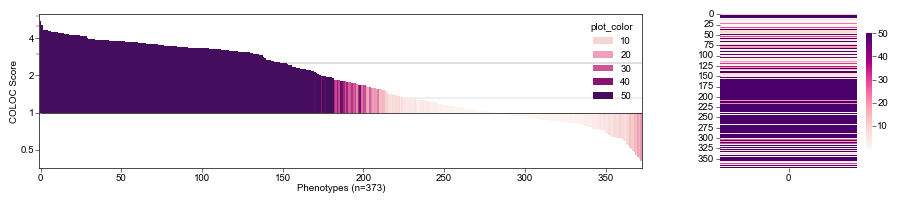

In [14]:
_, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(11, 2), gridspec_kw={'width_ratios':[7,2]})

df['plot_color'] = df.logq.apply(lambda z: min(z, 50))
sns.barplot(df.sort_values(by='log2SizeOE', ascending=False), x='trait_pair', y='log2SizeOE', hue='plot_color', 
            palette='RdPu', width=1, zorder=5, ax=ax1)
_ = ax1.set_xticks([])
ax1.hlines(y=[ np.log2(2.5),], xmin=-0.5, xmax=373, linestyle='-', color='black', alpha=0.6, 
           linewidth=0.3, zorder=0)
ax1.hlines(y=[ np.log2(1.3),], xmin=-0.5, xmax=373, linestyle='-', color='black', alpha=0.3, 
           linewidth=0.3, zorder=0)
ax1.hlines(y=0, xmin=-0.5, xmax=373.5, color='black', linewidth=0.5, zorder=6)
ax1.set_xlim(-0.75, 372.75)

ax1.set_yticks([-1, 0, 1, 2], labels=[0.5, 1, 2, 4])
_ = ax1.set_yticks(np.log2([3,5,6]), minor=True)
ax1.set_ylabel('COLOC Score')
ax1.set_xlabel(f'Phenotypes (n={len(df)})')
ax1.set_xticks([0, 50, 100, 150, 200, 250, 300, 350], labels = [0, 50, 100, 150, 200, 250, 300, 350])
sns.heatmap(df.plot_color.values.reshape(373, 1), cmap='RdPu', cbar_kws={'shrink':0.75})
plt.savefig(os.path.join(figdir, 'coloc_test.svg'), bbox_inches='tight')

In [15]:
print('Total sig coloc', len(df[(df.log2SizeOE > 0) & (df.q < 0.05)]))
print('Total sig coloc %', f'{100*len(df[(df.log2SizeOE > 0) & (df.q < 0.05)])/373:.1f}')

Total sig coloc 254
Total sig coloc % 68.1


In [20]:
print('Total strong', len(df[(df.log2SizeOE > np.log2(2))& (df.q < 0.05)]))
print('Total strong %', 100*len(df[(df.log2SizeOE > np.log2(2))& (df.q < 0.05)])/373)

Total strong 174
Total strong % 46.64879356568365


## Figure 2C - Categorical vs Continuous

In [33]:
gcat_meta = pd.read_csv(os.path.join(datadir, 'inputs', 'gcat_input_features_Mar28.tsv'), sep='\t')
gcat_meta = gcat_meta.rename(columns={'ClassificationFinal':'trait_type', 'DISEASE/TRAIT':'Trait',
                                     'StudyC':'TraitC', 'StudyR':'TraitR'})

In [34]:
###
over_df = pd.read_csv('/cellar/users/snwright/Data/RareCommon/outputs/overlap/March_2025/RV_GC_overlap.txt', sep='\t',
                     header=None, names=['trait_pair', 'param_set', 'n_common', 'n_rare', 'n_overlap', 'background', 'pval'])

over_df['EFO'] = over_df.trait_pair.apply(lambda x: map_trait_code(x))
over_df['StudyC'] = over_df.trait_pair.apply(lambda x: next((match.group() for match in re.finditer(r'GCST\d+', x)), None))
over_df['StudyR'] = over_df.trait_pair.apply(lambda x: x.split('_')[0])
over_df['Expected'] = over_df.n_rare * over_df.n_common / 19000
over_df['logp'] = -1 * np.log10(over_df['pval'] + 1e-250)
over_df.shape

(373, 12)

In [35]:
type_df = df.merge(gcat_meta, on=['TraitC', 'TraitR'], how='inner')
type_df['size_diff'] = type_df['N_C'] = type_df['N_R']
type_df['trait_pair'] = type_df['TraitR'] + '_' + type_df['TraitC']

In [36]:
type_df = type_df.merge(over_df, on='trait_pair', how='inner')

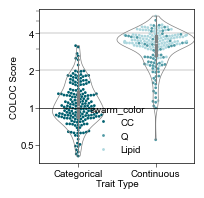

In [37]:
_ = plt.figure(figsize=(2,2))

type_df['swarm_color'] = type_df.apply(lambda x: 'Lipid' if x.Domain=='Lipid Measurment' else x.trait_type, axis=1)
sns.violinplot(type_df, x='trait_type', y='log2SizeOE', cut=0, fill=0,color='grey', zorder=2, linewidth=0.5, width=1)
sns.swarmplot(type_df, x='trait_type', y='log2SizeOE', hue='swarm_color', zorder=1, 
              palette=['#00606f', '#509aa5', '#ADD7DE'],  s=2)

ax1 = plt.gca()

ax1.hlines(y=[1, 2], xmin=-0.5, xmax=1.5, linestyle='-', color='grey', 
           linewidth=0.3, zorder=0)
ax1.hlines(y=0, xmin=-0.5, xmax=1.5, color='black', linewidth=0.5, zorder=6)
ax1.set_xlim(-0.5, 1.5)
ax1.set_yticks([-1, 0, 1, 2], labels=[0.5, 1, 2, 4])
_ = ax1.set_yticks(np.log2([3,5,6]), minor=True)
ax1.set_xlabel('Trait Type')
_ = ax1.set_xticks([0,1], labels=['Categorical', 'Continuous'])
_ = ax1.set_ylabel('COLOC Score')
plt.savefig(os.path.join(figdir, 'cc_vs_q.svg'), bbox_inches='tight')

In [20]:
mannwhitneyu(type_df[type_df.trait_type=='CC'].log2SizeOE.values,type_df[(type_df.trait_type=='Q')].log2SizeOE.values )

MannwhitneyuResult(statistic=1173.0, pvalue=1.0565521566904869e-54)

In [46]:
print('Average COLOC, Lipid Measurement:', f'{np.mean([2*x for x in type_df[type_df.Domain=="Lipid Measurment"].log2SizeOE.values]):.1f}')

Average COLOC, Lipid Measurement: 3.6


In [61]:
domain_counts = pd.DataFrame({'total':type_df.groupby('Domain').TraitR.count(), 
             'Colocalized': type_df[(type_df.q < 0.05) & (type_df.log2SizeOE > 0)].groupby('Domain').TraitR.count()}).fillna(0)
domain_counts['fraction'] = domain_counts.Colocalized / domain_counts.total
domain_counts.sort_values('fraction')

,total,Colocalized,fraction
Domain,,,
dermatological,1,0.0,0.000000
Pain,3,0.0,0.000000
Other,1,0.0,0.000000
Infection,18,4.0,0.222222
Neoplasm,26,9.0,0.346154
Skeletal,17,6.0,0.352941
Gastrointestinal,12,5.0,0.416667
Muscular,9,4.0,0.444444
Respiratory,9,4.0,0.444444


## Figure 2D

In [39]:
domain_map = {d:d for d in type_df.Domain.unique()}
domain_map['dermatological'] = 'Dermatological'
domain_map['Lipid Measurment'] = 'Lipid Measurement'
domain_map['Pain'] = 'Other'
domain_map['Hepatic'] = 'Other'

In [40]:
type_df['Domain'] = type_df.Domain.map(domain_map)

In [41]:
order = type_df.groupby('Domain').log2SizeOE.median().sort_values().index[::-1]

In [42]:
percent_continuous = type_df.groupby('Domain').trait_type.value_counts().reset_index().pivot(index='Domain', columns='trait_type', values='count'
                                                                                            ).reset_index().fillna(0)
percent_continuous['frac'] = percent_continuous['Q']/(percent_continuous['CC']+percent_continuous['Q'])

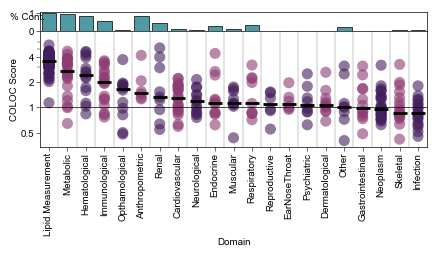

In [55]:
_, [ax2, ax1] = plt.subplots(nrows=2, ncols=1, figsize=(5, 1.75), gridspec_kw={'height_ratios':[0.5,3], 'hspace':0}, sharex=True)
sns.stripplot(type_df, x='Domain', y='log2SizeOE', hue='Domain', jitter=0, s=8,ax=ax1,
               alpha=0.6, legend=False, palette=['#441f5d', '#8d3b72']*10+['#441f5d'], order=order, hue_order=order)
percent_contuinuous = type_df.groupby('Domain').trait_type.value_counts()
sns.barplot(percent_continuous, x='Domain', y='frac', ax=ax2, edgecolor='black', saturation=1, color='#509aa5')

# add a median bar for each value of x
sns.pointplot(type_df.groupby('Domain').log2SizeOE.median().reset_index(), x='Domain', y='log2SizeOE', color='black', markers='_', dodge=True, order=order, zorder=200,
              linestyle='none', markersize=10, ax=ax1)#, hue='Domain', palette=['darkblue', 'royalblue']*10+['darkblue'], hue_order=order)
#sns.boxplot(type_df, x='Domain', y='log2SizeOE', color='black', fill=False, linewidth=0.5, fliersize=0, order=order, zorder=200)
ax1.tick_params(axis='x', rotation=90)
#ax1.hlines(y=np.log2(1.3), xmin=-0.5, xmax=20.5, color='grey',linewidth=0.5, linestyle='--', zorder=100)
ax1.hlines(y=0, xmin=-0.5, xmax=20.5, color='black',linewidth=0.5, linestyle='-', zorder=100)
#ax1.hlines(y=np.log2(2.5), xmin=-0.5, xmax=20.5, color='grey',linewidth=0.5, linestyle='--', zorder=100)
ax1.vlines(x=[i+0.5 for i in range(20)], ymin=-1.55, ymax=3, linewidth=0.3, color='grey')
ax1.set_xlim(-0.5, 20.5)
ax1.set_ylim(-1.55, 3)
ax1.set_yticks([-1, 0, 1, 2], labels=[0.5, 1, 2, 4])
_ = ax1.set_yticks(np.log2([3,5,6]), minor=True)
#sns.stripplot(type_df[type_df.log2SizeOE<0], x='Domain', y='log2SizeOE', hue='Domain', jitter=0.2, s=6,
#               alpha=0.7,  ax=ax2, legend=False, palette=['maroon', 'indianred']*10+['maroon'], order=order, hue_order=order)
plt.ylabel('COLOC Score')
ax2.set_ylabel('% Cont.', rotation=0)
plt.savefig(os.path.join(figdir, 'domain_manhattan_initial.svg'), bbox_inches='tight')